### Dipendenze

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.ticker as ticker

In [6]:
def format_seconds_to_minutes(val, pos):
    if val < 60:
        return f"{val:.2f} s"
    else:
        minutes = val / 60
        return f"{minutes:.2f} min"

In [7]:
mypath = os.getcwd() + '/data/data_total/'
chepeso = [1, 5, 10, 25] #todo
metric_to_compare = 'f1-score'
time_column_name = 'time'
timeUsed_column_name = 'timeUsed'
random_state_column = 'randomState'
datasets_to_process = ['XGB', 'RUMORE']
tollerance = 0.01
time_column_available = True
positions_to_plot = ['both sensors', 'left wrist', 'right pocket']


=== PROCESSING POSITION: both sensors ===

Processing weight: 1
Processing weight: 5
Processing weight: 10
Processing weight: 25


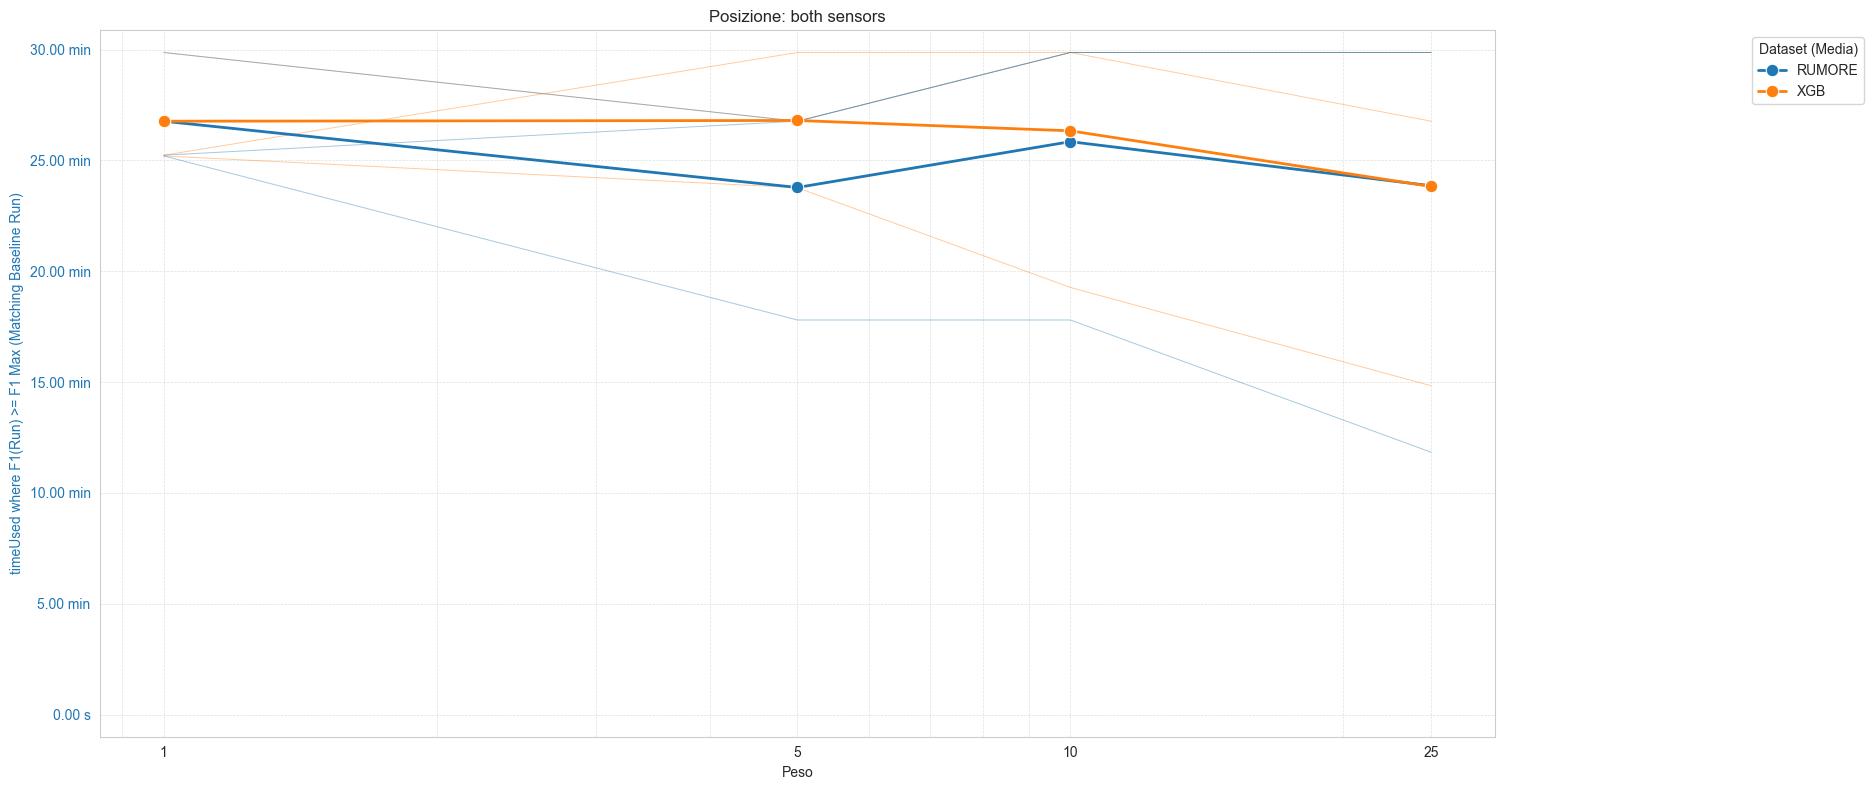


=== PROCESSING POSITION: left wrist ===

Processing weight: 1
Processing weight: 5
Processing weight: 10
Processing weight: 25


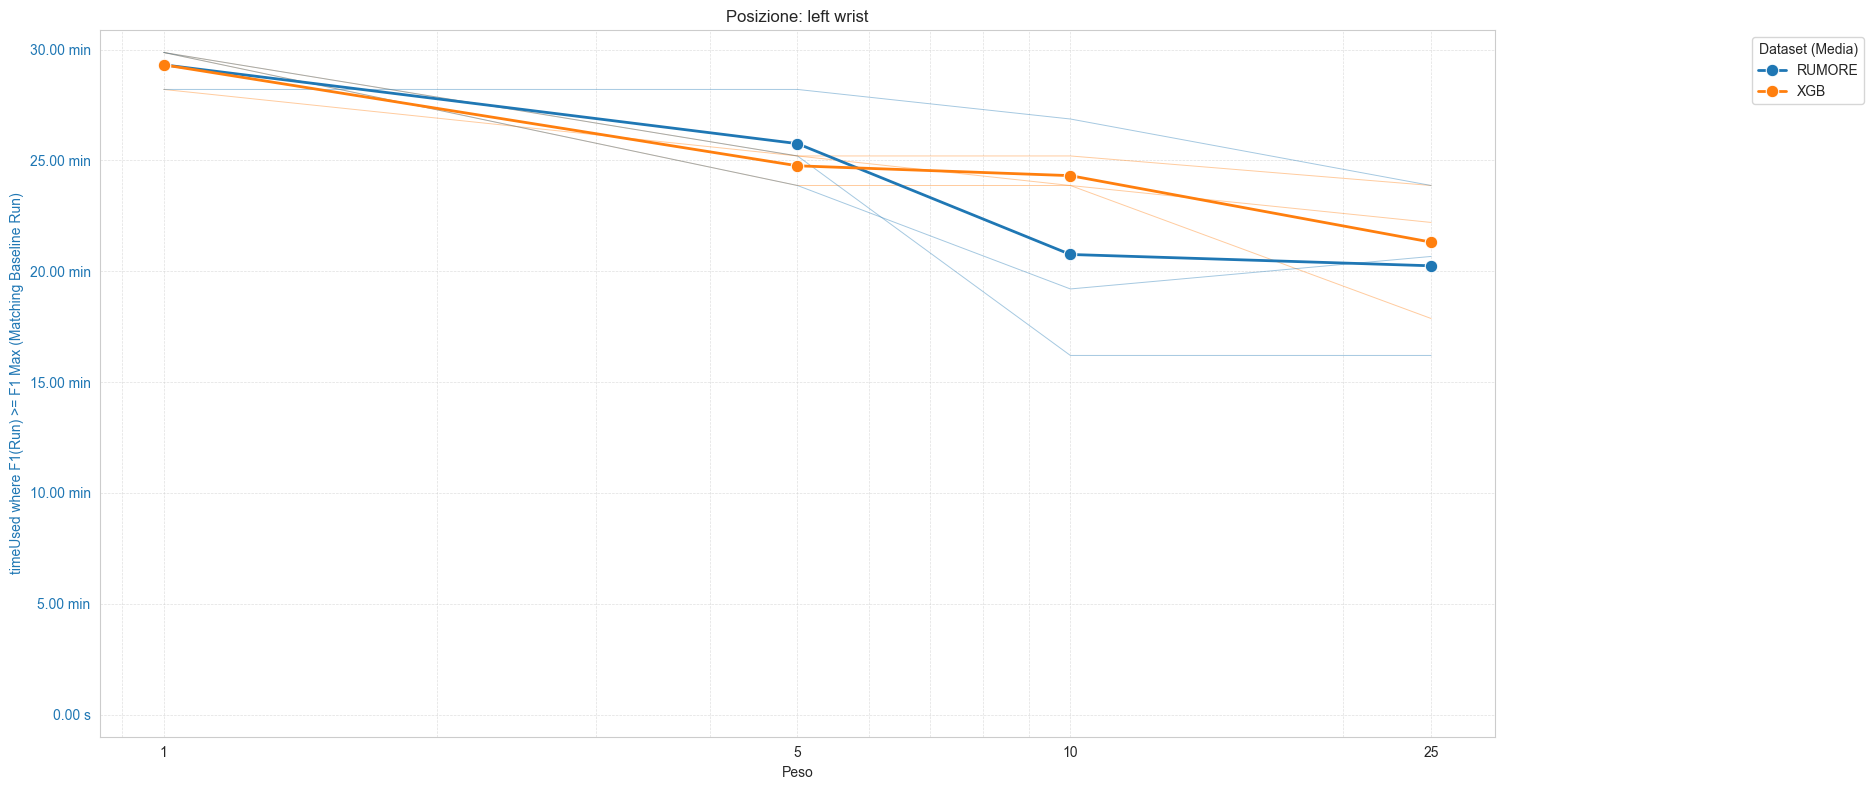


=== PROCESSING POSITION: right pocket ===

Processing weight: 1
Processing weight: 5
Processing weight: 10
Processing weight: 25


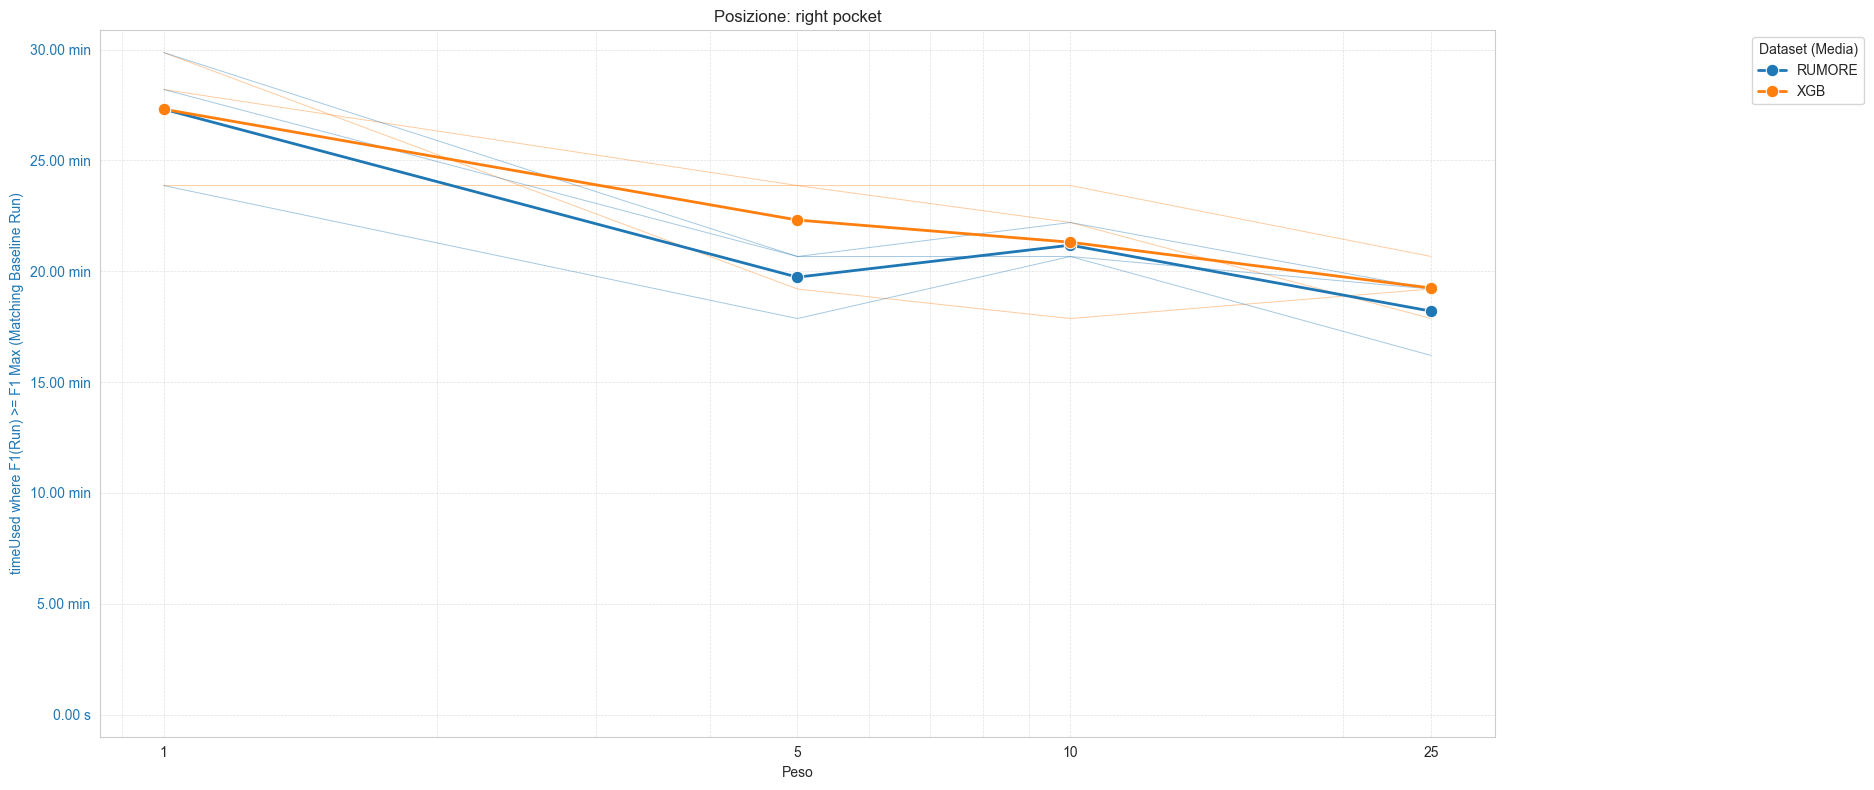

In [10]:
# --- Ciclo su ogni posizione ---
for position_to_plot in positions_to_plot:
    print(f"\n=== PROCESSING POSITION: {position_to_plot} ===\n")
    try:
        # --- Caricamento Dati ---
        df_singolo_full = pd.read_csv(mypath + 'modelXGBtotal_base.csv', header=0)
        df_singolo_full = df_singolo_full[df_singolo_full['weight'] == 1]
        df_singolo_full = df_singolo_full[df_singolo_full['position'] == position_to_plot]
        if df_singolo_full.empty:
            raise FileNotFoundError(f"Nessun dato SINGOLO (XGB peso=1) per {position_to_plot}")

        required_cols_singolo = [metric_to_compare, timeUsed_column_name, random_state_column]
        if not all(col in df_singolo_full.columns for col in required_cols_singolo):
            raise ValueError(f"Colonne essenziali mancanti nel dataset SINGOLO.")

        df_pos = df_singolo_full[
            (df_singolo_full['position'] == position_to_plot) &
            (df_singolo_full['randomState'].isin(df_singolo_full['randomState'].unique()))
        ]
        grouped = df_pos.groupby(['randomState', 'timeUsed'])[metric_to_compare].mean()
        max_medie = grouped.groupby('randomState').max()
        baseline_max_f1_dict = max_medie.to_dict()

        if pd.Series(baseline_max_f1_dict).isnull().any():
            print("Attenzione: Trovati NaN nei valori F1 massimi del baseline per random state.")

        all_other_dfs = []
        datasets_files = {
            'XGB': mypath + 'modelXGBtotal_base.csv',
            'RUMORE': mypath + 'modelXGBtotal_varianza.csv',
        }
        temp_datasets_to_process = list(datasets_to_process)
        for name, filepath in datasets_files.items():
            if name in temp_datasets_to_process:
                try:
                    df_loaded = pd.read_csv(filepath, header=0)
                    df_loaded['dataset'] = name
                    df_loaded = df_loaded[df_loaded['position'] == position_to_plot]

                    required_cols = ['weight', timeUsed_column_name, metric_to_compare, random_state_column]
                    if not all(col in df_loaded.columns for col in required_cols):
                        print(f"Attenzione: Colonne mancanti in {filepath} ({name}). Salto.")
                        datasets_to_process.remove(name)
                        continue

                    cols_to_keep = ['weight', timeUsed_column_name, metric_to_compare, 'dataset', random_state_column]
                    if time_column_name in df_loaded.columns:
                        cols_to_keep.append(time_column_name)
                    all_other_dfs.append(df_loaded[cols_to_keep])

                except FileNotFoundError:
                    print(f"Attenzione: File non trovato {filepath} ({name}). Salto.")
                    datasets_to_process.remove(name)
                except Exception as e:
                    print(f"Errore caricamento {filepath} ({name}): {e}. Salto.")
                    datasets_to_process.remove(name)

        if not all_other_dfs:
            raise ValueError("Nessun dato valido caricato per i dataset da confrontare.")
        df_all_others = pd.concat(all_other_dfs, ignore_index=True)
        df_all_others = df_all_others[df_all_others['weight'].isin(chepeso)]

        if time_column_name not in df_all_others.columns:
            time_column_available = False
            print(f"\nAttenzione: Colonna tempo '{time_column_name}' non disponibile.")

    except FileNotFoundError as e:
        print(f"Errore caricamento file: {e}")
        continue
    except ValueError as e:
        print(f"Errore nei dati: {e}")
        continue
    except Exception as e:
        print(f"Errore generico caricamento dati: {e}")
        continue

    # --- Matching timeUsed per ogni run ---
    results_individual = []
    unique_random_states = df_all_others[random_state_column].unique()

    for weight_val in chepeso:
        print(f"Processing weight: {weight_val}")
        df_all_others_current_weight = df_all_others[df_all_others['weight'] == weight_val]

        for dataset_name in datasets_to_process:
            for r_state in unique_random_states:
                current_f1_s_max = baseline_max_f1_dict.get(r_state, np.nan)
                if not np.isfinite(current_f1_s_max):
                    results_individual.append({ 'weight': weight_val, 'dataset': dataset_name, 'random_state': r_state, 'matching_timeUsed': np.nan, 'corresponding_time': np.nan }); continue

                df_current_run = df_all_others_current_weight[ (df_all_others_current_weight['dataset'] == dataset_name) & (df_all_others_current_weight[random_state_column] == r_state) ]
                if df_current_run.empty:
                    results_individual.append({ 'weight': weight_val, 'dataset': dataset_name, 'random_state': r_state, 'matching_timeUsed': np.nan, 'corresponding_time': np.nan }); continue

                current_f1_map = df_current_run.groupby(timeUsed_column_name)[metric_to_compare].mean()
                current_time_map = None
                if time_column_available and time_column_name in df_current_run.columns:
                    current_time_map = df_current_run.groupby(timeUsed_column_name)[time_column_name].mean()

                timeUsed_values_to_check = sorted(current_f1_map.index.unique())
                if not timeUsed_values_to_check: # Aggiunto controllo lista vuota
                    results_individual.append({ 'weight': weight_val, 'dataset': dataset_name, 'random_state': r_state, 'matching_timeUsed': np.nan, 'corresponding_time': np.nan }); continue


                matching_timeUsed = np.nan
                corresponding_time = np.nan

                # Ciclo sui valori di timeUsed per trovare il match
                for t_used in timeUsed_values_to_check:
                    f1_d = current_f1_map.get(t_used)
                    if f1_d is not None and np.isfinite(f1_d):
                        if f1_d >= current_f1_s_max:
                            matching_timeUsed = t_used
                            if current_time_map is not None:
                                corresponding_time = current_time_map.get(t_used)
                            break # Trovato il primo t_used

                if np.isnan(matching_timeUsed):
                    # Assegna il massimo timeUsed di QUESTA run specifica
                    max_t_used_for_run = timeUsed_values_to_check[-1] # Ultimo elemento lista ordinata
                    matching_timeUsed = max_t_used_for_run
                    if current_time_map is not None:
                        corresponding_time = current_time_map.get(max_t_used_for_run)

                results_individual.append({
                    'weight': weight_val,
                    'dataset': dataset_name,
                    'random_state': r_state,
                    'matching_timeUsed': matching_timeUsed, # Ora questo non dovrebbe essere NaN se timeUsed_values_to_check non era vuota
                    'corresponding_time': corresponding_time
                })

    # --- Creazione DataFrame ---
    df_individual = pd.DataFrame(results_individual)
    df_average = df_individual.groupby(['weight', 'dataset'])[['matching_timeUsed', 'corresponding_time']].mean().reset_index()

    # --- Plotting ---
    plot_data_y1_avg = df_average.dropna(subset=['matching_timeUsed'])
    plot_data_y1_ind = df_individual.dropna(subset=['matching_timeUsed'])

    if plot_data_y1_avg.empty:
        print("\nNessun 'matching timeUsed' medio valido trovato. Impossibile generare il grafico.")
        continue
    else:
        fig, ax1 = plt.subplots(figsize=(24, 8))
        unique_datasets = df_average['dataset'].unique()
        color_palette = sns.color_palette(n_colors=len(unique_datasets))
        dataset_colors = dict(zip(unique_datasets, color_palette))

        sns.lineplot(
            data=plot_data_y1_ind, x='weight', y='matching_timeUsed', hue='dataset',
            palette=dataset_colors, units='random_state', estimator=None,
            linewidth=0.7, alpha=0.4, legend=False, ax=ax1
        )
        sns.lineplot(
            data=plot_data_y1_avg, x='weight', y='matching_timeUsed', hue='dataset',
            palette=dataset_colors, style='dataset', marker='o', markersize=9, dashes=False,
            linewidth=2, legend='full', ax=ax1
        )

        ax1.set_xlabel("Peso")
        ax1.set_xscale('log')
        ax1.set_xticks(chepeso)
        ax1.set_xticklabels(chepeso)
        y1_axis_label = f"timeUsed where F1(Run) >= F1 Max (Matching Baseline Run)"
        ax1.set_ylabel(y1_axis_label, color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5, alpha=0.6)
        ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5, alpha=0.6)
        ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_seconds_to_minutes))
        ymax = df_singolo_full[df_singolo_full['position'] == position_to_plot]['timeUsed'].max()
        ax1.set_ylim(-60, ymax+60)

        # Crea ticks ogni 5 minuti
        tick_interval_seconds = 5 * 60  # 5 minuti = 300 secondi
        yticks = np.arange(0, ymax + tick_interval_seconds, tick_interval_seconds)
        ax1.set_yticks(yticks)

        handles, labels = ax1.get_legend_handles_labels()
        num_datasets = len(unique_datasets)
        handles, labels = handles[:num_datasets], labels[:num_datasets]
        ax1.legend(handles, labels, title='Dataset (Media)', bbox_to_anchor=(1.18, 1), loc='upper left')

        plt.title(f'Posizione: {position_to_plot}')
        fig.tight_layout(rect=[0, 0, 0.82, 1])
        plt.show()
        plt.close()